# Clustering Lyrical Data

Notebook Shortcuts:
1. [Introduction and Limitations](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/1_Introduction_and_Limitations.ipynb)
2. [Exploration](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/2_Exploration.ipynb)
3. [Cleaning Lyrics](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/3_Cleaning_Lyrics.ipynb)
4. [Topic Modeling](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/4_Topic_Modeling.ipynb) (you are here)
5. [More Topic Modeling and Clustering](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/5_More_Topic_Modeling_and_Clustering.ipynb)
6. [Conclusion and Wordclouds](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/6_Conclusion_and_Wordclouds.ipynb)

# 4: Topic Modeling

With a few different iterations of "clean" lyrics to choose from, now is the time to test out some topic modeling. Topic modeling attempts to find the topics hiddin within a number of documents. Now, the potential for abstractness is very high here as it can already be difficult to decipher lyrics and their meanings in particular cases; so, in doing topic modeling I anticipate finding some models that make a decent amount of sense, while others may not make any sense at all.

The python library Gensim is very useful when it comes to topic modeling. It also has a whole suite of its own NLP tools, but the topic modeling ones are the primary focus in this case. The types of topic modeling that will be performed with Gensim are:
1. Latent Dirichlet Allocation (LDA)
2. Latent Semantic Analysis/Indexing (LSA/LSI)
3. Non-Negative Matrix Factorization (NNMF)

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from gensim.models import LdaModel, LsiModel, CoherenceModel
from gensim.models.nmf import Nmf
from gensim import corpora

import logging
from time import localtime, time, asctime
from datetime import timedelta

pd.options.display.max_columns = 120

Set up a logfile path to store logs, Gensim doesn't log automatically.

In [3]:
year = localtime().tm_year
month = localtime().tm_mon
day = localtime().tm_mday
hour = localtime().tm_hour
minute = localtime().tm_min
second = localtime().tm_sec
approx_time = '{}_{}_{}_{}_{}_{}'.format(month, day, year, hour, minute, second)

logfile = r'logs\topic_modeling_log_' + approx_time + '.log'
logging.basicConfig(filename=logfile, level=logging.INFO, format='%(asctime)s : %(levelname)s : %(message)s')

## 4.1: Running the models

The first question is what version of "clean" data should be used? Since nouns generally provide the most context for what is actually being sung about in a text, the *lemmatized noun-only* version of the lyrics should provide some meaningful results.

In [4]:
lemma_base_stop_removed_clean_train = pd.read_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\lemma_base_stop_removed_clean_train.pkl')

This data isn't quite model ready, however. Gensim requires the tokens in the text to be in a dictionary that can easily be manipulated using gensim.

In [5]:
def string_series_to_gensim_dict(series):
    docs_of_words = series.apply(lambda x: x.split()).tolist()
    dictionary = corpora.Dictionary(docs_of_words)
    return dictionary

In [6]:
dictionary = string_series_to_gensim_dict(lemma_base_stop_removed_clean_train)

In [7]:
def create_corpus(series, dictionary):
    docs_of_words = series.apply(lambda x: x.split()).tolist()
    corpus = [dictionary.doc2bow(doc) for doc in docs_of_words]
    return corpus

In [8]:
corpus = create_corpus(lemma_base_stop_removed_clean_train, dictionary)

Going to run a loop that creates a bunch of models of varying topic length using various methods - this is going to take a long time.

In [9]:
def run_topic_model(model_type, num_topics, corpus, dictionary):
    '''Runs and returns a topic model object, model_type="LDA" OR "LSA" OR "NNMF"'''
    if model_type == 'LDA':
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         random_state=23,
                         num_topics=num_topics,
                         passes=10,
                         offset=50,
                         iterations=100,
                         eval_every=1,
                         per_word_topics=True,
                         chunksize=5000)
    elif model_type == 'LSA':
        model = LsiModel(corpus=corpus,
                         num_topics=num_topics,
                         id2word=dictionary,
                         chunksize=20000,
                         decay=1.0,
                         distributed=False,
                         onepass=False,
                         power_iters=10,
                         extra_samples=100)
    elif model_type == 'NNMF':
        model = Nmf(corpus=corpus,
                    num_topics=num_topics,
                    id2word=dictionary,
                    chunksize=5000,
                    passes=10,
                    kappa=1.0,
                    minimum_probability=0.01,
                    w_max_iter=200,
                    w_stop_condition=0.0001,
                    h_max_iter=50,
                    h_stop_condition=0.001,
                    eval_every=1,
                    normalize=True,
                    random_state=145)
    return model

In [10]:
models = {}
for model_type in ['LDA', 'NNMF', 'LSA']:
    for num_topics in [2, 5, 10, 15, 20, 40, 65, 100]:
        print(f'Executing topic modeling using {model_type} with {num_topics} topics:', end=' ')
        start_time = time()
        try:
            model = run_topic_model(model_type, num_topics, corpus, dictionary)
            total_seconds = time() - start_time
            print_time = str(timedelta(seconds=round(total_seconds)))
            print(f'DONE (Time to complete: {print_time})')
            models[(model_type, num_topics)] = model
        except:
            print(f'ERROR RUNNING MODEL @ {asctime()}')
print('ALL MODELS COMPLETE')

Executing topic modeling using LDA with 2 topics: DONE (Time to complete: 0:37:02)
Executing topic modeling using LDA with 5 topics: DONE (Time to complete: 0:41:14)
Executing topic modeling using LDA with 10 topics: DONE (Time to complete: 0:43:18)
Executing topic modeling using LDA with 15 topics: DONE (Time to complete: 0:43:55)
Executing topic modeling using LDA with 20 topics: DONE (Time to complete: 0:49:46)
Executing topic modeling using LDA with 40 topics: DONE (Time to complete: 0:39:21)
Executing topic modeling using LDA with 65 topics: DONE (Time to complete: 0:40:22)
Executing topic modeling using LDA with 100 topics: DONE (Time to complete: 0:44:48)
Executing topic modeling using NNMF with 2 topics: DONE (Time to complete: 0:22:11)
Executing topic modeling using NNMF with 5 topics: DONE (Time to complete: 0:26:32)
Executing topic modeling using NNMF with 10 topics: DONE (Time to complete: 0:30:26)
Executing topic modeling using NNMF with 15 topics: DONE (Time to complete: 

In [11]:
outfile = open(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\models\topic_models.pkl', 'wb')
pickle.dump(models, outfile)
outfile.close()

## 4.2: Inspecting Models

In [25]:
for model in models.keys():
    print(model)

('LDA', 2)
('LDA', 5)
('LDA', 10)
('LDA', 15)
('LDA', 20)
('LDA', 40)
('LDA', 65)
('LDA', 100)
('NNMF', 2)
('NNMF', 5)
('NNMF', 10)
('NNMF', 15)
('NNMF', 20)
('NNMF', 40)
('NNMF', 65)
('NNMF', 100)
('LSA', 2)
('LSA', 5)
('LSA', 10)
('LSA', 15)
('LSA', 20)
('LSA', 40)
('LSA', 65)
('LSA', 100)


All right! After a solid 13+ hours, the above models ran. So now is the time to dig into the results to see if there are any meaningful topics and if a particular model stands out.

In [103]:
def view_topics(model_type, num_topics, num_words=10):
    title_string = f'{model_type} with {num_topics} Topics: {num_words} Words'
    print(title_string)
    print('-' * len(title_string))
    topics_terms = models[(model_type, num_topics)].show_topics(num_topics=num_topics, num_words=num_words)
    topics = [topic_no + 1 for topic_no, _ in topics_terms]
    terms = [terms for _, terms in topics_terms]
    for topic, term in zip(topics, terms):
        print(f'Topic #{topic}: {term}')
        print('-' * len(title_string))

In [172]:
def topic_df(model_type, num_topics, num_words=10):
    title_string = f'{model_type} with {num_topics} Topics: {num_words} Words'
    print('-'*len(title_string))
    print(title_string)    
    print('-'*len(title_string))
    topics_terms = models[(model_type, num_topics)].show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
    topics_strings = [f'Topic_{topic+1}' for topic, _ in topics_terms]
    topic_top_words = [[word for word, _ in list_of_tups] for list_of_tups in [tups for _, tups in topics_terms]]
    topic_dict = {}
    for topics_string, topic_words in zip(topics_strings, topic_top_words):
        topic_dict[topics_string] = topic_words
    return pd.DataFrame(topic_dict)

### 4.2.1: Latent Semantic Analysis/Latent Semantic Indexing

So, Latent Semantic Analysis (aka Latent Semantic Indexing) is a topic modeling technique which, in this case, takes a bag of words representation of various texts (documents as the index, terms as the columns and counts as values) and uses Singular Value Decomposition to essentially boil everything down to the number of dimensions/topics specified. This is useful in determining the terms that are the most important for a particular corpus at potentially any dimension (as long as it's less than the number of documents).

In [85]:
view_topics('LSA', 2)

LSA with 2 Topics: 10 Words
---------------------------
Topic #1: 0.870*"love" + 0.255*"baby" + 0.205*"time" + 0.133*"heart" + 0.127*"way" + 0.117*"girl" + 0.099*"life" + 0.094*"night" + 0.089*"thing" + 0.087*"day"
---------------------------
Topic #2: 0.517*"time" + -0.481*"love" + 0.453*"baby" + 0.204*"girl" + 0.190*"way" + 0.160*"life" + 0.158*"night" + 0.152*"day" + 0.123*"thing" + 0.109*"heart"
---------------------------


So, love looks to be a very large indicator when things are boiled down to two topics. The first topic here primarily contains love, while the second one appears to lack it. Interpreted another way, the majority of songs are about a "girl", "baby", "heart" and "life", some are love songs, some are not. However, this is a very basic and broad representation of the corpus as a whole and doesn't provide much in terms of explainability and usefulness (other than getting a very broad grasp of the data).

In [86]:
view_topics('LSA', 5)

LSA with 5 Topics: 10 Words
---------------------------
Topic #1: 0.870*"love" + 0.255*"baby" + 0.205*"time" + 0.133*"heart" + 0.127*"way" + 0.117*"girl" + 0.099*"life" + 0.094*"night" + 0.089*"thing" + 0.087*"day"
---------------------------
Topic #2: 0.517*"time" + -0.481*"love" + 0.453*"baby" + 0.204*"girl" + 0.190*"way" + 0.160*"life" + 0.158*"night" + 0.152*"day" + 0.123*"thing" + 0.109*"heart"
---------------------------
Topic #3: -0.803*"baby" + 0.508*"time" + 0.144*"life" + 0.115*"day" + -0.094*"girl" + 0.086*"way" + 0.071*"heart" + 0.066*"world" + 0.063*"eye" + 0.053*"thing"
---------------------------
Topic #4: -0.607*"girl" + 0.550*"time" + 0.261*"baby" + -0.244*"way" + -0.172*"night" + -0.160*"life" + -0.157*"day" + -0.134*"heart" + -0.131*"world" + -0.116*"man"
---------------------------
Topic #5: 0.722*"girl" + 0.334*"time" + -0.296*"life" + -0.289*"way" + -0.230*"day" + -0.213*"heart" + -0.164*"night" + -0.094*"eye" + -0.086*"thing" + -0.073*"baby"
---------------------

The uppermost topics will be repeats (1/2) since SVD is a matrix operation and essentially we're just deciding to include more dimensions/columns. When looking at the third topic, the major difference is the lack of the term "baby" and not as much "girl". It also adds in "world" and "eye". This technique is quickly showing a weakness of not finding very many differentiated terms. I anticipate LDA and NNMF to do better in this respect.

In [87]:
view_topics('LSA', 10)

LSA with 10 Topics: 10 Words
----------------------------
Topic #1: 0.870*"love" + 0.255*"baby" + 0.205*"time" + 0.133*"heart" + 0.127*"way" + 0.117*"girl" + 0.099*"life" + 0.094*"night" + 0.089*"thing" + 0.087*"day"
----------------------------
Topic #2: 0.517*"time" + -0.481*"love" + 0.453*"baby" + 0.204*"girl" + 0.190*"way" + 0.160*"life" + 0.158*"night" + 0.152*"day" + 0.123*"thing" + 0.109*"heart"
----------------------------
Topic #3: -0.803*"baby" + 0.508*"time" + 0.144*"life" + 0.115*"day" + -0.094*"girl" + 0.086*"way" + 0.071*"heart" + 0.066*"world" + 0.063*"eye" + 0.053*"thing"
----------------------------
Topic #4: -0.607*"girl" + 0.550*"time" + 0.261*"baby" + -0.244*"way" + -0.172*"night" + -0.160*"life" + -0.157*"day" + -0.134*"heart" + -0.131*"world" + -0.116*"man"
----------------------------
Topic #5: 0.722*"girl" + 0.334*"time" + -0.296*"life" + -0.289*"way" + -0.230*"day" + -0.213*"heart" + -0.164*"night" + -0.094*"eye" + -0.086*"thing" + -0.073*"baby"
---------------

Again, not very much added value here. I'm thinking LSA is not the way to go.

### 4.2.2: Latent Dirichlet Allocation

Latent Dirichlet Allocation (LDA) is another form of topic modeling, again trying to find latent/hidden features. LDA assumes that documents with similar topics will use similar words when talking about a particular topic. Therefore certain terms will have a certain weight when it comes to a particular topic. It also requires the number of topics as a parameter. This should have better, more differentiated results than the LSA/LSI models above.

In [90]:
view_topics('LDA', 2, 15)

LDA with 2 Topics: 15 Words
---------------------------
Topic #1: 0.056*"love" + 0.038*"baby" + 0.024*"girl" + 0.015*"time" + 0.014*"man" + 0.013*"way" + 0.013*"thing" + 0.012*"night" + 0.011*"boy" + 0.010*"cause" + 0.010*"tonight" + 0.007*"money" + 0.006*"dance" + 0.006*"friend" + 0.006*"day"
---------------------------
Topic #2: 0.030*"time" + 0.022*"life" + 0.021*"heart" + 0.018*"day" + 0.016*"eye" + 0.016*"way" + 0.016*"love" + 0.015*"world" + 0.012*"night" + 0.011*"thing" + 0.010*"dream" + 0.010*"mind" + 0.009*"hand" + 0.008*"word" + 0.007*"soul"
---------------------------


Looking at the two topic solution, the first topic appears to again be primarily about love, but this time including the terms "man", "boy", "thing". This topic could be more generalized to love songs on the whole, and maybe more party centric ("money" & "dance")? The second topic is still very much love dependent, but it appears to be less pointed toward an individual and more idea based ("life", "time", "world", "dream", "mind", "soul").

In [91]:
view_topics('LDA', 5, 15)

LDA with 5 Topics: 15 Words
---------------------------
Topic #1: 0.070*"time" + 0.038*"way" + 0.036*"life" + 0.033*"thing" + 0.030*"day" + 0.020*"mind" + 0.018*"world" + 0.017*"eye" + 0.014*"heart" + 0.014*"word" + 0.013*"cause" + 0.012*"friend" + 0.011*"dream" + 0.010*"change" + 0.010*"face"
---------------------------
Topic #2: 0.017*"life" + 0.016*"soul" + 0.014*"world" + 0.013*"blood" + 0.012*"man" + 0.012*"eye" + 0.011*"death" + 0.009*"pain" + 0.008*"hand" + 0.008*"heart" + 0.008*"child" + 0.007*"war" + 0.007*"fear" + 0.006*"power" + 0.006*"mind"
---------------------------
Topic #3: 0.047*"night" + 0.021*"light" + 0.021*"day" + 0.017*"sky" + 0.017*"rain" + 0.017*"dance" + 0.015*"eye" + 0.014*"home" + 0.014*"star" + 0.014*"song" + 0.014*"tonight" + 0.013*"hand" + 0.012*"wind" + 0.011*"dream" + 0.011*"morning"
---------------------------
Topic #4: 0.021*"man" + 0.013*"money" + 0.012*"boy" + 0.009*"shit" + 0.008*"girl" + 0.008*"bitch" + 0.008*"rock" + 0.007*"cause" + 0.006*"head" +

The results from the above are probably the most distinct and useful thus far!

The first topic is hard to pin down, but again is more concept based ("time", "life", "world", "word", "dream", "change"). Topic #2 is a little more pointed toward mortality and the things that are connected to it ("life", "soul", "blood", "death", "pain", "war", "fear", "power") - pretty impressive topic there. Topic #3 appears to be concerned more with the elements and things connected to them ("night", "light", "day", "sky", "rain", "star", "wind", "morning"...). Topic #4 is of the more profane variety, interestingly includes the young versions of man and woman ("boy" & "girl") as well as "kid" itself. And of course Topic #5: love songs.

In [95]:
view_topics('LDA', 10, 7)

LDA with 10 Topics: 7 Words
---------------------------
Topic #1: 0.164*"thing" + 0.158*"world" + 0.137*"tonight" + 0.061*"mind" + 0.029*"need" + 0.028*"change" + 0.020*"lot"
---------------------------
Topic #2: 0.020*"soul" + 0.019*"blood" + 0.016*"death" + 0.015*"life" + 0.013*"world" + 0.011*"man" + 0.011*"war"
---------------------------
Topic #3: 0.056*"dance" + 0.054*"song" + 0.037*"rock" + 0.036*"music" + 0.035*"night" + 0.034*"people" + 0.030*"body"
---------------------------
Topic #4: 0.046*"man" + 0.017*"boy" + 0.009*"head" + 0.009*"woman" + 0.008*"kid" + 0.008*"friend" + 0.007*"year"
---------------------------
Topic #5: 0.164*"baby" + 0.094*"time" + 0.081*"way" + 0.057*"day" + 0.031*"night" + 0.020*"cause" + 0.017*"friend"
---------------------------
Topic #6: 0.394*"love" + 0.099*"heart" + 0.078*"girl" + 0.020*"kiss" + 0.017*"boy" + 0.016*"arm" + 0.016*"touch"
---------------------------
Topic #7: 0.052*"time" + 0.045*"life" + 0.022*"way" + 0.017*"word" + 0.016*"eye" + 0

I've limited the words to 7 above, just to keep each topic to one line (just know there are more words for each topic, that actually goes for all every single model).

Quick potential breakdown:
- Topic #1: another idea/conceptual topic
- Topic #2: mortality, life, death
- Topic #3: party/dance/music
- Topic #4: people 
- Topic #5: ???
- Topic #6: love - more physical
- Topic #7: another conceptual topic
- Topic #8: places and transport
- Topic #9: elements and part of day
- Topic #10: profane

**Quick aside:**

Each document is a mix of each of topics, so the question becomes, "How many topics are there in the corpus?" That question is tough to answer! And there probably isn't a "right" number. However, each song only contains so many nouns/terms, so it's likely that an individual song/document doesn't contain a large number of topics. But, the number of songs/documents is of a decent size. It's possible that there are thousands of potential topics. But that isn't very realistic for this particular use case, which is to pare down a song into its most relevant aspects. That's why I initially ran this with a maximum of 100 topics. The compute time is relatively long, and on my local machine I can't wait forever to find the "best" model. So the goal will be to find one that works decently well and roll with it.

**Another quick note:**

The display of topics is getting pretty tedious, so instead of viewing it in text and with the comparative weights attached, the topics will instead be converted to a DataFrame with each topic as a column as well as a selected amount of top words per topic!

In [176]:
topic_df('LDA', 15, 10)

----------------------------
LDA with 15 Topics: 10 Words
----------------------------


,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15
0,thing,soul,people,man,baby,love,life,home,night,money,change,girl,water,train,woman
1,world,blood,friend,boy,time,heart,time,piece,eye,shit,breathe,talk,air,skin,rock
2,tonight,death,dance,gun,way,girl,word,floor,dream,bitch,jump,game,hole,burn,music
3,mind,world,song,ride,day,kiss,way,door,day,fuck,action,bit,use,tree,body
4,head,child,night,car,cause,arm,eye,bone,light,girl,rose,boy,stranger,snow,work
5,need,hand,town,hell,thing,touch,mind,shake,sky,ass,garden,lady,danger,flame,roll
6,sleep,war,care,hand,night,boy,face,daddy,rain,niggas,table,cause,season,bell,turn
7,honey,man,lot,country,mind,hold,end,dog,star,cause,reaction,step,pleasure,desire,stop
8,wonder,life,street,mother,today,eye,pain,stone,wind,pop,satisfaction,guy,case,magic,radio
9,bed,angel,city,road,know,lover,lie,house,time,club,thorn,party,toy,brain,play


Interesting topics from above:
- Topic #3: gathering at a time and place
- Topic #4: driving
- Topic #6: physical love
- Topic #8: home - the place and things in it
- Topic #10: profane
- Topic #11: change/move
- Topic #15: music

In [175]:
topic_df('LDA', 20, 10)

----------------------------
LDA with 20 Topics: 10 Words
----------------------------


,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20
0,tonight,man,night,town,baby,love,time,break,day,lie,air,money,burn,today,song,soul,child,head,run,gun
1,thing,hand,dance,car,girl,heart,life,piece,eye,bone,breathe,shit,use,tomorrow,rock,life,angel,bed,snow,war
2,mind,home,people,boy,boy,arm,way,shame,dream,skin,action,bitch,flame,tree,music,world,work,honey,hide,people
3,need,woman,body,year,way,hold,day,shake,night,gold,spell,fuck,desire,train,roll,blood,lover,ground,soldier,brain
4,light,place,ride,kid,time,kiss,thing,stone,sky,something,believe,man,stranger,wind,turn,death,mother,foot,cover,mouth
5,feel,road,blue,friend,cause,way,world,hero,rain,drop,rose,ass,danger,yesterday,play,pain,peace,wall,bell,hate
6,touch,city,party,door,talk,fall,word,daddy,star,diamond,release,cause,fix,chain,sound,eye,joy,go,boom,blood
7,sleep,world,stop,home,babe,fool,mind,blame,morning,ring,garden,game,wire,track,radio,fear,son,hole,jump,bullet
8,cause,water,floor,day,bout,life,friend,mess,sun,plane,breathing,niggas,cat,number,beat,heart,king,dog,rise,machine
9,control,land,lot,room,thing,feeling,cause,come,light,shot,lung,club,feed,blow,sing,darkness,glory,finger,spin,animal


Some interesting topics from above:
- Topic #11: aspiration/gardening
- Topic #13: danger zone
- Topic #15: music
- Topic #16: life/mortality (again)
- Topic #17: peace/love/religious?
- Topic #20: war

In [182]:
topic_df('LDA', 40)

----------------------------
LDA with 40 Topics: 10 Words
----------------------------


,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29,Topic_30,Topic_31,Topic_32,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40
0,mind,place,people,ride,love,angel,life,home,night,drop,king,mama,right,tree,skin,soul,child,wall,run,body,game,water,nothing,rock,money,work,world,eye,bone,heart,hero,time,bite,care,girl,man,fall,head,rain,break
1,moment,road,song,ground,baby,summer,thing,piece,dream,crime,jump,school,spell,train,car,life,lover,honey,rise,blood,play,sea,something,bit,shit,hell,hand,word,dog,tonight,sunshine,way,box,air,boy,daddy,wave,morning,pain,talk
2,minute,town,stop,gun,heart,wing,friend,shake,sky,danger,smell,bag,gas,faith,drive,death,mother,hole,hide,brain,win,stone,listen,roll,bitch,go,dance,lie,shoe,arm,happiness,day,revolution,radio,woman,trouble,stand,bed,change,line
3,stay,light,blue,son,way,bird,year,glory,star,sweat,action,food,butterfly,wheel,book,world,knee,business,fight,death,blow,mountain,treasure,band,fuck,circle,music,truth,pay,step,doo,cause,language,share,lady,mess,ocean,kiss,turn,walk
4,doctor,city,fun,snow,touch,flower,day,youth,eye,test,rose,class,flash,track,sex,fear,brother,do,boom,flesh,rule,sand,leader,guitar,cause,save,chance,fool,price,soul,desert,thing,solution,remember,guy,hand,pick,room,tear,drink
5,miracle,street,sing,dust,thing,winter,time,string,day,police,garden,bus,somebodys,magic,tune,time,kind,crack,stick,enemy,rhythm,wine,mission,shine,ass,bow,party,reason,stranger,start,loneliness,need,stab,bet,bout,stuff,drum,hold,joy,leave
6,beat,land,sound,horse,cause,devil,end,lead,light,drip,raise,heel,movement,plane,weekend,pain,father,prison,drug,machine,push,river,plastic,stage,niggas,breathing,floor,face,wanna,chain,generation,today,doorway,card,baby,cat,speak,door,one,use
7,thought,war,bell,foot,time,season,kid,misery,wind,cop,sinner,charm,voodoo,wire,suit,darkness,sin,paint,pill,knife,ball,ship,roller,record,time,key,lot,voice,kill,light,failure,life,meadow,folk,cause,plan,harm,tomorrow,storm,catch
8,lifetime,mile,melody,rush,babe,thrill,lot,crash,sleep,dot,iron,drag,board,seat,downtown,peace,cover,boogie,swear,poison,grass,sugar,killing,kick,pop,lock,foot,answer,comfort,breath,sailor,know,evolution,hear,shell,momma,hurry,hand,worry,monster
9,beauty,gold,ring,cowboy,need,spring,hate,company,sun,justice,reaction,punk,click,ticket,dancin,earth,daughter,movin,gasoline,vein,fame,shade,raindrop,age,baby,job,romance,smile,feed,feeling,funk,matter,adventure,here,night,style,shore,window,sun,fever


Some interesting topics:
- Topic #3: sounds?
- Topic #4: western
- Topic #6: seasons
- Topic #9: dreams/space
- Topic #10: crime/law
- Topic #12: school
- Topic #16: mortality (again again)
- Topic #17: family
- Topic #19: fight or flight + drugs
- Topic #20: dying
- Topic #21: playing the game
- Topic #22: water + other elements
- Topic #24: rock & roll + band
- Topic #27: party
- Topic #35: guys/ladies/girls/boys
- Topic #36: parents?
- Topic #37: beach + ?

In [183]:
topic_df('LDA', 65)

----------------------------
LDA with 65 Topics: 10 Words
----------------------------


,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29,Topic_30,Topic_31,Topic_32,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59,Topic_60,Topic_61,Topic_62,Topic_63,Topic_64,Topic_65
0,mind,man,start,ride,love,hold,life,shake,friend,drop,rest,shit,color,city,act,death,lover,wall,room,rage,ship,walk,look,spell,kiss,honey,dance,eye,sin,tonight,mess,time,feel,nothing,control,devil,shoe,voice,money,break,downtown,work,hand,baby,day,house,night,rock,one,spirit,boy,world,thing,food,story,mean,card,drive,need,angel,hook,way,conversation,train,town
1,memory,war,stop,horse,heart,summer,home,misery,end,shot,flower,bitch,butterfly,magic,stain,soul,flame,hole,boom,poison,revolution,water,follow,nature,lip,sugar,chance,child,shame,body,happiness,day,attack,shelter,something,kick,mama,mother,hate,picture,haul,wonder,fall,girl,heart,die,light,play,bone,bell,fool,people,everything,girlfriend,power,stranger,crack,beauty,tree,wing,judge,woman,sake,dust,car
2,thought,fight,blue,rush,arm,leave,line,youth,door,sweat,seed,fuck,guard,pity,dancin,earth,burn,dog,stick,direction,mission,sea,flag,desert,mouth,grave,music,lie,win,blood,nation,cause,pressure,loser,king,fault,vein,brother,trouble,minute,tangle,joy,ground,night,dream,meet,sky,roll,stone,action,gold,song,brand,bump,glory,police,sleigh,sex,rope,shell,conscience,talk,dark,hero,day
3,circle,gun,age,hat,cause,winter,matter,company,enemy,test,rose,ass,lane,mention,childhood,peace,desire,blow,surrender,heartbeat,press,wave,raise,curtain,daddy,save,lot,praise,dollar,step,doo,place,lift,meat,tie,mask,pull,son,worry,use,pepper,darling,foot,cause,life,bounce,star,party,count,church,rule,head,string,map,ice,cop,seal,soldier,tell,freedom,salt,run,shout,track,kid
4,kind,land,news,cowboy,night,heartache,truth,sadness,sink,drip,garden,money,vice,walking,abuse,blood,crash,clock,toast,whore,solution,river,leader,size,taste,lock,floor,cover,feed,skin,generation,today,stab,culture,hip,chaos,needle,family,rise,shoulder,hatchet,hurt,turn,babe,soul,porch,wind,fun,flow,silver,edge,year,puppet,pump,note,traffic,climbing,machine,wolf,fantasy,position,change,sleeping,midnight,home
5,miracle,battle,figure,daylight,touch,everybodys,answer,fence,shut,lick,sinner,niggas,artist,rabbit,lipstick,world,murder,head,possibility,salvation,video,sand,waiting,ache,tongue,temptation,dancing,surprise,kill,breath,shower,face,fry,vulture,twist,wear,running,prayer,crime,catch,cobwebs,comfort,stand,lady,word,b,morning,radio,bite,sweetheart,wheel,bit,ring,egg,cream,code,sandwich,plane,thread,fly,like,help,condition,speed,hair
6,change,mercy,art,boot,time,colour,question,tragedy,heaven,worm,lay,cause,green,magician,bruise,life,victory,toe,system,reflection,handle,ocean,odd,collide,doctor,patience,difference,tale,steel,flesh,valley,care,gay,raindrop,crown,mark,pair,sister,animal,weight,uptown,repeat,piece,bout,tear,glove,sun,beat,listen,reaction,noise,word,obsession,graveyard,standing,vine,pencil,bag,velvet,bow,office,hell,judgment,liar,street
7,state,bomb,charm,trail,feeling,breeze,number,scheme,side,pavement,plant,game,radar,weave,ink,pain,blade,nail,spinning,thief,film,drink,crow,stroke,pill,pour,crowd,cross,tail,death,grain,know,perspective,tumble,fashion,e,lawyer,letter,deal,wait,batter,notice,watch,time,pain,drown,day,bird,hurry,parade,danger,sing,diamond,listening,swimming,karma,gap,pack,forest,blessing,member,hide,goodness,ticket,head
8,trip,bullet,sit,crystal,kiss,autumn,price,fountain,swim,calling,voodoo,pop,domino,billion,creep,hell,defeat,tick,doom,snake,shark,shore,anchor,tunnel,cure,sensation,groove,disguise,harmony,pleasure,u,reason,alie

Topics...interesting:
- Topic #1: thinking/state of mind
- Topic #2: war
- Topic #4: cowboys/life on the range
- Topic #6: seasons and feelings from them
- Topic #11: gardening/sin (religious?)
- Topic #12: profane
- Topic #14: magic + ???
- Topic #16: death/life
- Topic #17: passion/fire/blades
- Topic #22: bodies of water/beach
- Topic #23: leadership/following
- Topic #25: mouth
- Topic #27: dance
- Topic #30: murder
- Topic #35: power/control
- Topic #38: family
- Topic #44: baby/girl/babe
- Topic #47: light/dark/elements
- Topic #56: police
- Topic #58: travel somewhere beautiful
- Topic #60: angels (literal/not literal) and the like

In [184]:
topic_df('LDA', 100)

-----------------------------
LDA with 100 Topics: 10 Words
-----------------------------


,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29,Topic_30,Topic_31,Topic_32,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59,Topic_60,Topic_61,Topic_62,Topic_63,Topic_64,Topic_65,Topic_66,Topic_67,Topic_68,Topic_69,Topic_70,Topic_71,Topic_72,Topic_73,Topic_74,Topic_75,Topic_76,Topic_77,Topic_78,Topic_79,Topic_80,Topic_81,Topic_82,Topic_83,Topic_84,Topic_85,Topic_86,Topic_87,Topic_88,Topic_89,Topic_90,Topic_91,Topic_92,Topic_93,Topic_94,Topic_95,Topic_96,Topic_97,Topic_98,Topic_99,Topic_100
0,mind,diamond,stop,planet,cause,machine,line,finger,dream,test,tunnel,shade,dress,desire,skin,soul,lover,wall,room,order,brand,trumpet,field,look,bread,wonder,dance,money,game,end,bout,rain,place,paper,control,blue,space,brother,love,break,pack,work,hand,baby,heart,angel,tree,friend,water,hide,gold,song,worry,blow,story,lock,drop,fun,forest,face,bell,blood,storm,sense,care,miracle,freedom,child,town,smoke,message,watch,tonight,lot,air,pain,trip,piece,rise,time,power,gang,fight,body,sleep,youth,girl,thing,point,ice,party,devil,life,trick,card,day,feed,boy,nothing,way
1,change,record,answer,rider,know,stuff,sign,guitar,sky,like,burrow,summertime,fix,magic,sin,death,kind,hole,boom,whore,bag,lake,seed,pride,coat,go,foot,shit,shame,step,doo,ground,home,intention,fly,shoe,soap,wing,heart,picture,downtown,job,fall,kiss,eye,fame,trouble,road,circle,action,number,rock,fault,food,glory,suit,vice,mama,failure,smile,church,hate,yesterday,fence,ride,fruit,cover,mother,street,scream,sweat,burn,light,summer,breath,mistake,block,mouth,state,waste,daddy,expectation,war,run,imagine,nail,man,people,throw,leg,attitude,bet,rest,creature,nature,night,pig,need,bone,world
2,peace,shore,question,crystal,chance,heartache,wine,chest,star,medium,mole,thirst,makeup,spell,drive,darkness,lust,glass,doom,curtain,ship,vocal,plant,mirror,pussy,ring,floor,bitch,joy,case,desert,sound,shout,here,shot,house,bumper,sister,way,use,goodnight,darling,one,touch,word,meet,sea,help,soldier,reaction,enemy,music,image,girlfriend,pool,swim,entertainer,everything,disaster,misery,silver,hell,snow,gain,drink,addiction,name,son,city,wound,harmony,return,night,something,breathe,guy,neighborhood,taste,clock,luck,family,rubble,gun,count,inside,tender,woman,lie,gas,cream,movin,mask,praise,stain,try,head,arrow,doctor,dog,today
3,thought,spin,listen,drowning,feeling,everybodys,set,string,wind,tube,roaring,evidence,plague,course,sex,fear,daylight,wood,serenity,afternoon,pull,driveway,cradle,half,sell,phone,shake,fuck,wanna,second,generation,make,present,buck,self,bottle,gratitude,motion,emotion,dawn,bury,wage,stand,honey,tear,adore,bird,stay,ocean,thread,paint,play,hurry,coffee,zone,sheep,tar,plane,stress,fantasy,hear,man,season,gaze,hair,spit,needle,mile,car,want,drip,stick,shine,winter,heat,brain,dealer,bite,gift,year,wife,opponent,win,surrender,error,hammer,talk,color,trap,tea,juice,feelin,die,press,hall,morning,worm,toy,stone,day
4,problem,killer,raise,clay,feel,kitchen,situation,pound,eye,lifestyle,captor,silhouette,stab,distraction,dancin,earth,bop,boogie,sincerity,defeat,bow,detail,cotton,sight,button,distance,dancing,ass,comfort,lose,parent,lead,keeper,sting,tie,bar,plead,shut,kiss,release,pole,overtime,land,lip,arm,fortune,chain,edge,daughter,satisfaction,echo,soul,feather,cup,swimming,flock,nighttime,excuse,wolf,laugh,hook,truth,weather,border,horse,breakin,dad,father,country,poison,language,cage,turn,sugar,smell,pleasure,slut,candy,dime,crime,fighting,tarantula,battle,direction,logic,fog,fool,hero,good,bum,wonderland,collection,age,obsession,warrior,bed,tag,witch,givin,matter
5,pressure,boat,ask,a

Topics of interest (only if they haven't been seen before):
- Topic #20: rape?
- Topic #27: dancing - specifically of the foot variety
- Topic #42: work/job
- Topic #77: drugs/smoking

**LDA Evaluation:**

LDA worked very well compared to LSA/LSI. Many of the topics are discernible. The 100 topic version was very vague and doesn't seem to be very useful. On the other end the 2 topic model is too broad. Somewhere between the 5-65 topic range is probably the most useful depending on how broad/vague the use case. In this particular case the 40 topic option looked the best. But before sticking with it, NNMF may have something even better.

### 4.2.3: Non-Negative Matrix Factorization 

When it comes to Non-Negative Matrix Factorization (NNMF/NMF), it basically does what it's called. It takes a non-negative matrix (in this case the bag of words document-term matrix), and tries to break it down into two factor matricies that if multiplied together would give approximately the source matrix. In order to approximate these two factor matricies, a sort of gradient descent is performed to minimize the distance between the source matrix and the multiplied result of the two factored matricies. So, what did NNMF find in this case?

In [188]:
view_topics('NNMF', 2)

NNMF with 2 Topics: 10 Words
----------------------------
Topic #1: 0.048*"time" + 0.042*"baby" + 0.022*"girl" + 0.021*"way" + 0.019*"life" + 0.018*"night" + 0.017*"day" + 0.015*"heart" + 0.014*"thing" + 0.011*"eye"
----------------------------
Topic #2: 0.390*"love" + 0.027*"heart" + 0.025*"baby" + 0.013*"way" + 0.011*"thing" + 0.008*"girl" + 0.007*"cause" + 0.007*"eye" + 0.007*"need" + 0.006*"world"
----------------------------


The two topic model looks very similar to that of LDA's 2 topic solution.

In [189]:
view_topics('NNMF', 5)

NNMF with 5 Topics: 10 Words
----------------------------
Topic #1: 0.048*"way" + 0.047*"girl" + 0.031*"day" + 0.023*"night" + 0.022*"world" + 0.015*"tonight" + 0.014*"heart" + 0.013*"man" + 0.013*"thing" + 0.012*"eye"
----------------------------
Topic #2: 0.362*"baby" + 0.037*"girl" + 0.012*"cause" + 0.012*"boy" + 0.011*"thing" + 0.010*"tonight" + 0.009*"rock" + 0.009*"night" + 0.009*"body" + 0.007*"dance"
----------------------------
Topic #3: 0.115*"life" + 0.033*"heart" + 0.024*"night" + 0.017*"thing" + 0.015*"eye" + 0.012*"mind" + 0.011*"dream" + 0.009*"man" + 0.009*"soul" + 0.007*"hand"
----------------------------
Topic #4: 0.481*"love" + 0.030*"heart" + 0.011*"thing" + 0.007*"need" + 0.007*"cause" + 0.007*"way" + 0.007*"eye" + 0.005*"kiss" + 0.005*"fall" + 0.005*"touch"
----------------------------
Topic #5: 0.220*"time" + 0.016*"mind" + 0.012*"thing" + 0.009*"eye" + 0.008*"day" + 0.008*"cause" + 0.006*"hand" + 0.006*"man" + 0.006*"line" + 0.006*"place"
-----------------------

In comparison to LDA's 5 topic solution, this doesn't seem to be as convincing.

In [190]:
topic_df('NNMF', 10)

-----------------------------
NNMF with 10 Topics: 10 Words
-----------------------------


,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10
0,day,thing,baby,love,way,girl,night,time,heart,life
1,eye,man,cause,thing,love,boy,tonight,mind,eye,world
2,dream,dance,tonight,need,cause,world,world,cause,soul,mind
3,boy,hand,boy,cause,thing,cause,light,line,dream,dream
4,face,people,rock,kiss,mind,body,dream,place,mind,soul
5,hand,world,body,touch,word,friend,hand,eye,word,death
6,word,woman,honey,fall,change,money,star,friend,world,pain
7,rain,money,need,song,place,need,eye,end,break,people
8,today,cause,babe,feel,time,guy,sky,change,hand,eye
9,man,head,mind,eye,friend,lady,morning,hand,tear,end


The most discernible topics here are maybe 7 and 10. Again, LDA's 10 topic solution appeared to be better and more differentiated.

In [191]:
topic_df('NNMF', 15)

-----------------------------
NNMF with 15 Topics: 10 Words
-----------------------------


,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15
0,way,night,heart,dance,man,day,mind,girl,love,boy,life,eye,baby,time,thing
1,change,tonight,soul,magic,world,today,head,boy,need,cause,world,world,cause,line,hand
2,cause,light,break,floor,hand,dream,hand,world,touch,money,dream,dream,rock,cause,love
3,word,dream,dream,hand,woman,year,change,body,kiss,friend,soul,sky,body,place,night
4,dream,star,word,music,people,home,soul,cause,cause,bitch,death,tear,honey,end,word
5,place,morning,tear,body,soul,morning,body,guy,fall,shit,pain,face,babe,year,cause
6,today,sleep,arm,jump,child,tomorrow,line,lady,song,talk,people,light,need,waste,change
7,feel,sky,pain,party,place,night,thought,bout,feel,rock,end,soul,kiss,moment,need
8,light,party,star,chance,light,baby,place,need,lover,work,light,hand,touch,fall,lot
9,help,city,cause,rock,land,summer,blood,dime,care,word,place,pain,tonight,change,song


Topic #4, #7, #9, and #11 make the most sense here. But a trend with NNMF is that the topics tend to be more alike to one another in comparison to LDA.

In [192]:
topic_df('NNMF', 20)

-----------------------------
NNMF with 20 Topics: 10 Words
-----------------------------


,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20
0,dream,time,girl,mind,love,dance,way,thing,world,baby,need,day,man,life,boy,cause,rock,night,eye,heart
1,thing,line,body,word,fall,floor,change,tonight,soul,babe,work,today,woman,time,hand,love,light,light,hand,soul
2,night,end,boy,rain,touch,magic,word,care,people,body,home,year,money,death,people,friend,place,tonight,sky,break
3,sleep,year,guy,change,kiss,music,thing,tomorrow,end,honey,dream,tomorrow,friend,soul,money,bitch,face,morning,tear,word
4,song,waste,lady,head,song,jump,today,lot,child,touch,know,morning,shit,pain,bitch,baby,roll,star,lie,tear
5,life,friend,bout,pain,lover,body,talk,party,blood,kiss,body,rain,bitch,people,shit,shit,head,sky,star,arm
6,friend,moment,floor,soul,feel,tonight,feel,light,place,woman,train,friend,head,end,run,know,body,sleep,blood,pain
7,talk,fall,ride,thing,feeling,party,help,town,word,ride,matter,summer,town,moment,head,honey,soul,end,face,head
8,year,place,car,body,arm,people,friend,moment,sky,come,place,song,girl,blood,water,thing,turn,summer,soul,hand
9,hope,door,dime,line,care,chance,road,friend,war,lady,music,sun,hell,rest,friend,kiss,rain,day,love,start


These aren't all terrible, but again, they don't appear to be as differentiable as LDA's solutions.

In [193]:
topic_df('NNMF', 40)

-----------------------------
NNMF with 40 Topics: 10 Words
-----------------------------


,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29,Topic_30,Topic_31,Topic_32,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40
0,dance,face,year,baby,night,boy,dream,cause,eye,run,mind,heart,home,place,light,tonight,thing,blood,soul,man,end,love,rain,need,world,people,life,doo,girl,day,lover,way,word,head,money,bitch,hand,time,friend,woman
1,magic,road,change,babe,morning,care,work,rock,sky,water,change,break,music,face,star,party,lot,pain,boom,town,touch,kiss,war,body,child,work,death,sky,lady,today,chance,help,lie,hold,summer,shit,raise,waste,end,dog
2,floor,line,talk,honey,sleep,town,sleep,roll,tear,game,thought,tear,turn,step,city,tomorrow,care,death,control,gun,today,fall,fall,work,peace,town,pain,star,guy,morning,ride,feel,work,bed,time,money,song,moment,help,lady
3,jump,memory,tear,kiss,star,toy,star,know,lie,play,peace,arm,song,honey,sky,love,bout,hell,death,son,break,song,sky,rock,sky,care,rest,child,floor,tomorrow,town,lot,song,game,arm,fuck,hold,fall,song,child
4,music,smile,bit,rock,city,country,sky,care,star,drip,coffee,start,bounce,town,morning,star,know,flesh,angel,land,tomorrow,feel,wind,shake,war,time,moment,satisfy,bout,sun,door,game,truth,rock,night,niggas,land,door,talk,food
5,chance,time,pain,come,song,boyfriend,hope,fall,sleep,gun,control,piece,play,space,darkness,sleep,truth,body,roll,hell,kiss,feeling,child,feel,star,street,fight,man,body,hour,girl,feeling,voice,bone,ride,ass,air,tick,care,town
6,party,know,fear,lady,sky,game,bung,morning,goodbye,walk,fear,star,radio,ride,shine,time,matter,floor,darkness,plan,feel,care,tear,touch,earth,lot,chance,funk,dime,week,bit,walk,fight,foot,honey,hoe,pocket,line,badger,feel
7,body,mind,song,touch,sight,dope,nightmare,matter,angel,hide,state,pain,care,room,turn,moment,reason,skin,music,fool,water,hold,pain,breathe,hope,power,truth,mess,club,sky,home,know,pain,boom,step,nigga,sand,bomb,family,hair
8,shake,matter,kiss,know,child,joy,fantasy,break,look,ass,reason,feeling,stop,star,sun,drink,ring,child,hell,daddy,wind,babe,sun,bit,truth,child,fear,care,car,song,arm,play,know,voice,kiss,talk,foot,chance,enemy,blue
9,beat,train,walk,talk,party,kiss,tomorrow,song,smile,river,pain,attack,beat,city,snow,town,s,bone,rock,guy,know,hate,storm,tell,nothing,peace,reason,look,know,summer,car,matter,mouth,room,cash,work,love,crime,girlfriend,honey


NNMF appears to shadow/echo it's own topics here and there. Interesting, but not very useful.

In [194]:
topic_df('NNMF', 65)

-----------------------------
NNMF with 65 Topics: 10 Words
-----------------------------


,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29,Topic_30,Topic_31,Topic_32,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59,Topic_60,Topic_61,Topic_62,Topic_63,Topic_64,Topic_65
0,head,rain,love,bounce,world,boy,care,morning,party,work,bitch,look,rock,man,eye,water,need,honey,friend,word,feel,place,line,love,baby,pain,body,light,dance,step,heart,blood,love,soul,hand,fight,night,song,record,dream,day,time,tonight,way,death,turn,girl,dog,music,ride,woman,people,girl,year,mind,thing,time,money,lover,life,cause,doo,war,time,sex
1,talk,tear,touch,sleep,change,toy,talk,one,floor,shake,shit,run,roll,son,face,drip,change,end,end,face,matter,face,run,thing,babe,touch,home,star,magic,fool,break,town,fall,boom,raise,hold,sleep,summer,spin,star,today,end,tomorrow,change,sky,sky,time,bone,today,shit,lady,power,lady,road,change,change,home,home,train,rest,know,satisfy,lie,waste,drive
2,hold,wind,kiss,today,peace,boyfriend,know,feeling,reason,job,fuck,glory,beat,gun,tear,air,touch,kiss,help,truth,fall,hold,today,baby,kiss,bit,touch,city,floor,watch,start,lie,kiss,star,hold,break,star,kiss,change,sleep,tomorrow,chance,star,today,end,life,skin,sky,play,roll,love,street,dime,tear,thought,lot,face,cash,walk,moment,run,funk,peace,fall,lot
3,bed,sun,fall,lover,end,town,matter,lie,town,break,niggas,voice,punk,plan,smile,sea,tell,love,talk,voice,touch,space,chain,kiss,touch,tear,shake,darkness,jump,door,arm,ground,arm,control,land,fall,city,play,killer,memory,sun,run,arm,help,hell,radio,use,face,beat,blue,food,child,car,break,peace,bout,tear,car,boom,chance,hold,thing,child,tick,bout
4,game,sky,arm,bumper,earth,country,air,truth,tonight,watch,ass,face,rockin,land,goodbye,break,know,junk,badger,mouth,air,fall,tomorrow,babe,come,wind,floor,shine,chance,walk,piece,street,touch,darkness,pocket,stand,sight,sing,game,tomorrow,week,break,moment,lot,child,play,guy,food,rhythm,car,fool,lot,club,talk,coffee,ring,know,stop,child,change,tell,mess,run,bomb,face
5,foot,patter,hold,beauty,nothing,game,nothing,control,lot,make,hoe,floor,tonite,daddy,star,walk,breathe,baby,family,thought,know,home,door,share,lady,brain,control,snow,shake,game,tear,flesh,hate,angel,air,arm,bed,radio,play,hope,hour,door,kiss,walk,hate,fall,kill,angel,radio,piece,child,hide,know,wind,state,know,moment,dollar,arm,story,game,fever,gun,crime,snow
6,room,cloud,heart,bed,today,dope,time,angel,city,art,nigga,touch,kid,fool,lip,river,kiss,sugar,enemy,problem,stop,door,shake,fall,talk,fear,watch,sun,rhythm,room,attack,skin,feeling,power,sand,beat,end,melody,sex,bung,smile,stop,sleep,bell,know,silence,wine,star,air,chance,fall,peace,floor,snow,memory,talk,star,pay,talk,reason,play,touch,battle,reason,church
7,hole,storm,babe,tomorrow,hope,joy,hair,child,go,bit,game,foot,stop,brother,lie,wind,s,way,girlfriend,letter,kiss,room,walk,feeling,know,game,make,home,dancing,wall,chance,vein,romance,gold,foot,moment,morning,wind,chain,nightmare,brand,ground,eih,game,wall,sleep,bout,givin,sound,know,luck,town,ass,home,control,s,memory,niggas,know,hope,make,lady,soldier,goodbye,boy
8,boom,pitter,feeling,summer,star,kiss,business,tomorrow,foot,hurt,pussy,drive,boom,town,hair,praise,help,girl,story,heart,feeling,smile,gun,hold,bout,flame,sweat,shadow,beat,stone,heartbeat,city,babe,shadow,touch,end,shadow,fever,time,fantasy,sunshine,feeling,drink,tell,fear,ground,mistake,bird,country,shoe,hair,sound,kiss,tree,blow,truth,smile,gold,door,truth,bit,fall,fall,change,drug
9,voice,fall,fool,house,child,noise,say,wind,door,know,pop,beat,world,guy,sky,breath,hold,lip,phone,breath,make,break,sign,touch,phone,shame,let,flame,ro

Topics #2, #3, #5, #11, #13, #14, #15, #16, #18, #25, #28, #29, #37, #38, #40, #41, #45, #49, #50, #55 and #63 all appear to have some useful and relatively discernible topics (there is some overlap still). Some of these are more interesting than others, but it looks like NNMF is finding some connections that LDA wasn't so good at finding.

In [195]:
topic_df('NNMF', 100)

------------------------------
NNMF with 100 Topics: 10 Words
------------------------------


,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25,Topic_26,Topic_27,Topic_28,Topic_29,Topic_30,Topic_31,Topic_32,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59,Topic_60,Topic_61,Topic_62,Topic_63,Topic_64,Topic_65,Topic_66,Topic_67,Topic_68,Topic_69,Topic_70,Topic_71,Topic_72,Topic_73,Topic_74,Topic_75,Topic_76,Topic_77,Topic_78,Topic_79,Topic_80,Topic_81,Topic_82,Topic_83,Topic_84,Topic_85,Topic_86,Topic_87,Topic_88,Topic_89,Topic_90,Topic_91,Topic_92,Topic_93,Topic_94,Topic_95,Topic_96,Topic_97,Topic_98,Topic_99,Topic_100
0,end,roll,hell,run,thing,mind,change,heart,word,need,road,wall,world,sex,pain,money,game,home,bone,dance,man,eye,work,day,step,air,baby,friend,care,place,song,bitch,feel,time,touch,love,head,break,dream,love,woman,love,arm,people,angel,light,rain,cause,fight,help,lover,woman,tonight,boom,sky,fool,town,today,boy,party,baby,hold,love,fall,door,kiss,way,ass,tomorrow,life,sleep,blood,look,child,stop,breathe,line,music,soul,star,hand,summer,honey,body,ground,night,turn,snow,doo,rock,love,tear,girl,train,hate,talk,face,lie,water,dance
1,morning,rock,talk,reason,lot,thought,witness,start,voice,tell,truck,hole,peace,morning,tear,cash,play,lead,dog,shake,son,smile,shake,morning,watch,breath,babe,badger,cause,space,play,shit,know,waste,darkness,heart,bed,shit,hope,time,mother,cause,death,lot,know,city,patter,piece,hide,one,boom,matter,eih,control,chain,wind,city,yesterday,toy,ride,cause,shit,baby,cause,room,lip,lot,shot,trouble,moment,floor,death,nothing,memory,beat,magic,feeling,play,darkness,blue,raise,fever,junk,floor,chance,morning,radio,lot,satisfy,punk,romance,life,guy,ride,sleep,year,smile,fear,drip,magic
2,start,mystery,lot,matter,bout,peace,beat,attack,mouth,s,mile,shadow,earth,drive,brain,car,answer,phone,skin,rhythm,plan,goodbye,job,year,walk,hair,come,family,know,room,sing,fuck,make,moment,skin,hate,hole,bit,bung,kind,eye,feeling,glory,street,moment,darkness,sun,truth,reason,chance,bust,lady,club,bleed,cloud,war,minute,tomorrow,boyfriend,floor,babe,breath,bit,bounce,floor,love,bell,street,way,rest,tonight,flesh,mirror,war,street,jump,matter,walk,power,love,land,winter,sugar,shake,foot,city,burn,voice,funk,shit,share,death,lady,track,death,walk,bass,truth,walk,floor
3,hope,niggas,trouble,gun,ring,coffee,chance,piece,letter,know,manager,room,hope,smile,heart,dollar,trust,stone,givin,light,land,danger,make,sun,alright,drop,lady,girlfriend,hair,land,line,niggas,color,tick,breath,kind,voice,chain,nightmare,drum,hide,night,sun,power,wing,shine,cloud,use,shadow,ice,shot,food,moment,room,sun,dog,blue,morning,country,shake,lady,know,babe,reason,walk,power,thought,shake,sorrow,truth,drink,vein,s,soldier,dancin,reason,ride,rhythm,shadow,moon,pocket,wind,enemy,watch,sound,sight,play,tree,mess,rockin,hate,time,dime,chain,whore,kid,morning,eye,sea,jump
4,walk,smoke,day,cover,reason,state,time,heartbeat,problem,funk,bit,truth,nothing,bout,fear,pay,fuck,street,flesh,bun,gun,lip,art,week,room,wind,know,enemy,business,city,radio,hoe,bout,crime,eye,romance,toe,piece,fantasy,heart,child,know,child,peace,reason,morning,storm,know,game,wind,kind,luck,sight,animal,wing,peace,go,street,dope,drink,come,gravity,boom,catch,heaven,goodbye,tell,kid,something,reason,bed,skin,leave,year,power,shake,know,radio,gold,car,sand,sun,drop,skin,sun,shadow,know,one,fever,tonite,kind,line,bout,ghost,word,shit,poker,tell,river,chance
5,goodbye,tour,story,son,s,blow,hope,stone,thought,hope,way,voice,truth,church,shame,niggas,number,daddy,lot,drop,guy,sight,watch,hour,foot,moment,go,phone,matter,leave,melody,nigga,skin,bomb,shadow,share,thought,sweat,reality,share,record,kind,praise,way,joy,

Similar to the 65 topic solution above, this one appears to have some usefulness, arguably it's better than the 100 topic LDA solution, but that wasn't one of the best ones in the first place. Again, there appears to be some overlapping/shadowing of particular terms and topics. In some spots, however, it is quite impressive how on point the topics seem to be (e.g. Topic #88 looks like very wintry).

**NNMF Evaluation:**

NNMF got better as the dimensions increased, in the future it may be worth exploring higher dimensions than even 100 as the topics garnered are sometimes pretty specific, but this can be quite time consuming (big matricies like that actually take a long time to calculate - the 100 topic version took over 2 hours to compute). Even so, in this case, LDA is arguably better as its topics appear to be a little more differentiated from one another and may perform better at tagging/categorizing songs.

## 4.3: A deeper look at LDA (5-65 topics)

Since LDA was the best topic model when it came to the eye test (which is completely subjective, but language generally is as well), it is probably of use to look at the coherence scores to try and see which models are better with an actual number. Now coherence's aim is to actually test all the pairwise similarities between all the words in the corpus, and from that estimates how "coherent" each topic is. It then aggregates the scores for each topic to return the coherence score for the model. This isn't a perfect system! There isn't really a perfect system for determining whether a topic model is useful, but hopefully this will reveal the "better" model of all the LDA specific models.

In [228]:
doc_tokens = [x for x in lemma_base_stop_removed_clean_train.str.split()]

In [204]:
lda_models_of_interest = {}
for model_type, num_topics in models.keys():
    if model_type == 'LDA':
        if (num_topics >= 5) & (num_topics <= 65):
            lda_models_of_interest[(model_type, num_topics)] = models[(model_type, num_topics)]

In [232]:
coherence_scores = {}
for model_type, num_topics in lda_models_of_interest.keys():
    start_time = time()
    print(f'{asctime()}: Finding coherence score for {model_type} model with {num_topics} topics...', end='')
    try:
        coherence_model = CoherenceModel(model=models[(model_type, num_topics)], texts=doc_tokens, dictionary=dictionary, coherence='c_v')
        coherence_scores[(model_type, num_topics)] = coherence_model.get_coherence()
        total_seconds = time() - start_time
        print_time = str(timedelta(seconds=round(total_seconds)))
        print(f'OPERATION SUCCESS (Time to complete: {print_time})')
    except:
        print(f'OPERATION FAIL @ {asctime()}')

Tue Mar 10 16:13:28 2020: Finding coherence score for LDA model with 5 topics...OPERATION SUCCESS (Time to complete: 0:00:38)
Tue Mar 10 16:14:06 2020: Finding coherence score for LDA model with 10 topics...OPERATION SUCCESS (Time to complete: 0:01:05)
Tue Mar 10 16:15:11 2020: Finding coherence score for LDA model with 15 topics...OPERATION SUCCESS (Time to complete: 0:01:25)
Tue Mar 10 16:16:35 2020: Finding coherence score for LDA model with 20 topics...OPERATION SUCCESS (Time to complete: 0:01:53)
Tue Mar 10 16:18:29 2020: Finding coherence score for LDA model with 40 topics...OPERATION SUCCESS (Time to complete: 0:03:06)
Tue Mar 10 16:21:35 2020: Finding coherence score for LDA model with 65 topics...OPERATION SUCCESS (Time to complete: 0:03:58)


In [242]:
names = [str(name) for name in coherence_scores.keys()]
scores = [score for score in coherence_scores.values()]

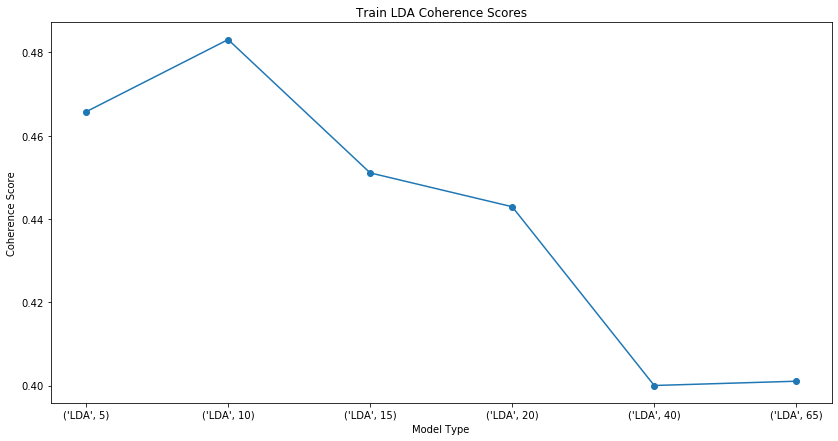

In [250]:
plt.figure(figsize=(14,7))
plt.plot(names, scores, marker='o')
plt.xlabel('Model Type')
plt.ylabel('Coherence Score')
plt.title('Train LDA Coherence Scores')
plt.show()

Those coherence scores really aren't bad. Interestingly, it appears as if models in the 5 to 15 range may actually provide the most useful results. This isn't really a bad thing as it could potentially result in easier clustering of the topics. I am curious how they compare when the model is used on the validation set. 

### 4.3.1: Coherence on the validation set

First the test set needs to be brought in and transformed the same way as the training set has been (lemmatizing and limiting to nouns).

In [270]:
%%capture
from tqdm import tqdm
try:
    tqdm._instances.clear()
    tqdm.pandas()
except:
    tqdm.pandas()

In [268]:
import spacy
import regex as re
import string

In [254]:
test = pd.read_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\test.pkl')

Now referring back to the prior notebook the same steps to clean the training data will be performed on the test data. That will require the clean_text function as well as removing stop words and finally using spacy to lemmatize and keep only nouns.

In [267]:
def clean_text(text):
    text = re.sub(r'\[.*\]', ' ', text) #gets rid of any brackets ('[' and ']') as well as any text within the brackets
    text = re.sub(r'\(.*?\d+.*?\)', ' ', text) #gets rid of any parenthesis with numbers inside (generally indicates repetition of section)
    text = re.sub(r'.*\bverse\b.*', ' ', text, flags=re.IGNORECASE) #gets rid of any lines containing the word "verse" exactly case independent
    text = re.sub(r'.*instrumental.*', ' ', text, flags=re.IGNORECASE) #mass majority of "instrumental" occurring in lyrics is an indicator for an instrumental section
    text = re.sub(r'.*chorus.*', ' ', text, flags=re.IGNORECASE) #mass majority of "chorus" occurring in lyrics is an indicator for where a chorus appears
    text = re.sub(r'.*\bbridge\b.*', ' ', text, flags=re.IGNORECASE) #majority of "bridge" exact are indicators for the bridge section of a song
    text = re.sub(r'\w+:', ' ', text) #get rid of any leading artists using a colon
    text = re.sub(r'\w*\d+\w*', ' ', text) #get rid of any strings containing numbers
    text = ''.join([char for char in text if char not in string.punctuation]) #get rid of all punctuation
    text = text.lower() #converts to lowercase
    text = ' '.join(text.split()) #clean up any whitespace
    text = re.sub(r'\w*[^a-z ]+\w*', ' ', text) #gets rid of any non-alpha or non-space characters or words containing them
    text = re.sub(r'([a-z])\1\1+', r'\1', text) #fixes any cases where a character is repeated 3 times or more (i.e. yeeeeeah --> yeah)
    text = ' '.join(text.split()) #clean up any whitespace again
    return text

Bring in stopwords.

In [256]:
infile_stopwords = open(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\stopwords\base_stopwords.pkl', 'rb')
stopwords = pickle.load(infile_stopwords)
infile_stopwords.close()

Load spacy and the function to use it.

In [259]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

In [260]:
def lemmatize_pos(text, allowed_postags=['NOUN']):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    text = ' '.join(lemmas)
    return text

Create a function to clean a series from the start!

In [262]:
def unclean_to_lemmas(series):
    clean_text_series = series.progress_apply(clean_text)
    base_stop_removed_clean_series = clean_text_series.progress_apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))
    lemma_base_stop_removed_clean_series = base_stop_removed_clean_series.progress_apply(lambda x: lemmatize_pos(x))
    return lemma_base_stop_removed_clean_series

In [271]:
lemma_test = unclean_to_lemmas(test)

100%|████████████████████████████████████████████████████████████████████████████| 29256/29256 [07:18<00:00, 66.78it/s]


Going to go ahead and do the same for the holdout set - so I won't have to do it later.

In [272]:
holdout = pd.read_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\holdout.pkl')

In [273]:
lemma_holdout = unclean_to_lemmas(holdout)

100%|████████████████████████████████████████████████████████████████████████████| 36569/36569 [08:49<00:00, 69.06it/s]


Go ahead and dump those for future use as well.

In [274]:
lemma_test.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\lemma_test.pkl')
lemma_holdout.to_pickle(r'C:\Users\philb\Repos\Thinkful_repo\projects\unsupervised_capstone\pickle\data\lemma_holdout.pkl')

In [275]:
def text_to_tokens(series):
    return [x for x in series.str.split()]

Convert the docs to tokens.

In [276]:
test_tokens = text_to_tokens(lemma_test)

In [277]:
coherence_scores = {}
for model_type, num_topics in lda_models_of_interest.keys():
    start_time = time()
    print(f'{asctime()}: Finding coherence score for {model_type} model with {num_topics} topics...', end='')
    try:
        coherence_model = CoherenceModel(model=models[(model_type, num_topics)], texts=test_tokens, dictionary=dictionary, coherence='c_v')
        coherence_scores[(model_type, num_topics)] = coherence_model.get_coherence()
        total_seconds = time() - start_time
        print_time = str(timedelta(seconds=round(total_seconds)))
        print(f'OPERATION SUCCESS (Time to complete: {print_time})')
    except:
        print(f'OPERATION FAIL @ {asctime()}')

Tue Mar 10 18:08:56 2020: Finding coherence score for LDA model with 5 topics...OPERATION SUCCESS (Time to complete: 0:00:19)
Tue Mar 10 18:09:14 2020: Finding coherence score for LDA model with 10 topics...OPERATION SUCCESS (Time to complete: 0:00:27)
Tue Mar 10 18:09:41 2020: Finding coherence score for LDA model with 15 topics...OPERATION SUCCESS (Time to complete: 0:00:31)
Tue Mar 10 18:10:12 2020: Finding coherence score for LDA model with 20 topics...OPERATION SUCCESS (Time to complete: 0:00:36)
Tue Mar 10 18:10:48 2020: Finding coherence score for LDA model with 40 topics...OPERATION SUCCESS (Time to complete: 0:00:57)
Tue Mar 10 18:11:46 2020: Finding coherence score for LDA model with 65 topics...

C:\Users\philb\Miniconda3\envs\unsupervised_nlp\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\philb\Miniconda3\envs\unsupervised_nlp\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


OPERATION SUCCESS (Time to complete: 0:01:16)


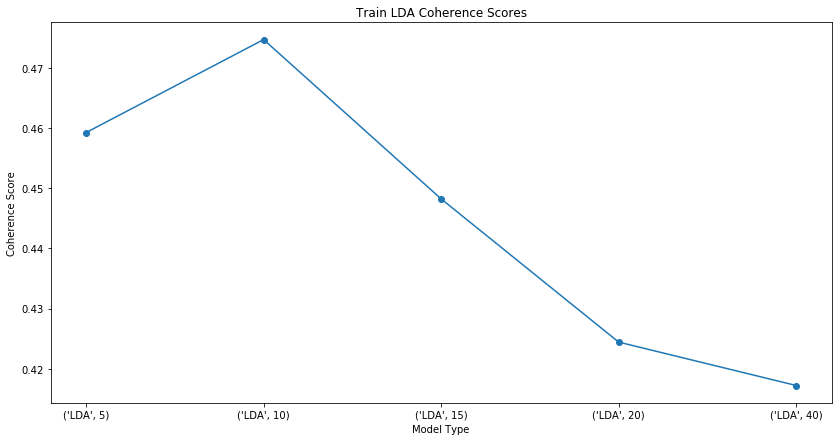

In [278]:
names = [str(name) for name in coherence_scores.keys()]
scores = [score for score in coherence_scores.values()]
plt.figure(figsize=(14,7))
plt.plot(names, scores, marker='o')
plt.xlabel('Model Type')
plt.ylabel('Coherence Score')
plt.title('Train LDA Coherence Scores')
plt.show()

What the above indicates to me is that LDA somewhere between 5 and 15 will probably have the best results, for both the training and testing set the coherence score was highest at 10 topics. But as the other topic numbers between 5 and 15 have yet to be executed, that will be the next step in order to find the best model.

## Shortcuts

Notebook Shortcuts:
1. [Introduction and Limitations](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/1_Introduction_and_Limitations.ipynb)
2. [Exploration](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/2_Exploration.ipynb)
3. [Cleaning Lyrics](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/3_Cleaning_Lyrics.ipynb)
4. [Topic Modeling](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/4_Topic_Modeling.ipynb) (you are here)
5. [More Topic Modeling and Clustering](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/5_More_Topic_Modeling_and_Clustering.ipynb)
6. [Conclusion and Wordclouds](https://github.com/philbowman212/Thinkful_repo/blob/master/projects/unsupervised_capstone/6_Conclusion_and_Wordclouds.ipynb)